# COURSERA CAPSTONE PROJECT

## The Battle of the Neighborhoods

### Japanese Restaurants in New York City

#### Introduction

I am going to explore the best places for Japanese Restaurants in New York City. One of world wide Japanese company is willing to open new restaurant there. Thus, it want to understand locations better through exploring neighborhoods and boroughs.
Firstly, I want to know a number of Japanese Restaurants in New York City.
Secondly, I need to understand qualities (ratings) of such a Restaurants there.
Additionally, I will attempt to answer the questions “Where should I open a Japanese Restaurant?” and “Where should I stay If I want great Japanese food?”

#### Data

In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Japanese restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

#### Methodology

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare will be used to locate all venues and then filtered by Japanese restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings

• Finally, the data be will be visually assessed using graphing from various Python libraries.

#### Problem Statement

1. What is / are the best location(s) for Japanese cuisine in New York City?
2. In what Neighborhood and/or borough should I open a Japanese restaurant to have the best chance of being successful?
3. Where would I go in New York City to have the best Japanese food?

Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

My variables

In [ ]:
CLIENT_ID = 'yourCLIENT_ID' # your Foursquare ID
CLIENT_SECRET = 'yourCLIENT_SECRET' # your Foursquare Secret
VERSION = '20200101'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Functions that will be used later

In [21]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=1000
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Now lets use the above codes to get our initial NYC data

In [22]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [23]:
ny_data.shape

(306, 4)

Now that we have our initial data, let's start analyzing it. We can see below that Manhattan has the least number of neighborhoods in all five boroughs.

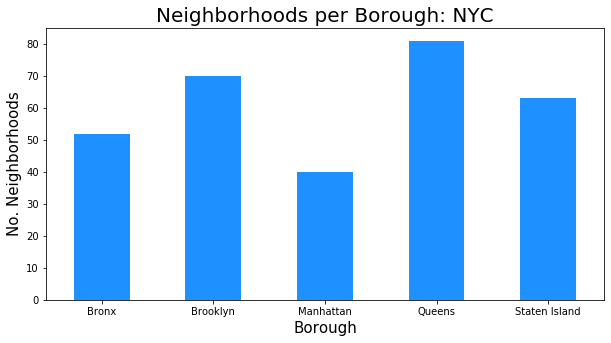

In [24]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Let’s analyze further and see how many japanese restaurants there are in each neighborhood and borough and graph the results.

In [ ]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    print(row)
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [26]:
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [28]:
japanese_rest_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
198,198,Brooklyn,Homecrest,4d6adae62ea9b1f7cb22ca28,Fuji Hana
199,199,Brooklyn,Homecrest,4bfb16ebd2b720a16395326a,Omiya Sushi
200,200,Staten Island,Richmond Valley,4bc898de15a7ef3b40697bda,Buddha Lounge
201,201,Staten Island,Richmond Valley,584de48c01f433697d786f21,Fushimi Tottenville
202,202,Queens,Malba,4c6038b654ac0f4736f7b421,Akiyama™ Sushi


In [29]:
japanese_rest_ny = japanese_rest_ny.drop(labels = 'Unnamed: 0', axis = 1)

In [30]:
japanese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse


In [31]:
japanese_rest_ny.shape

(203, 4)

As we continue our analysis, we see below that Brooklyn has the highest number if Japanese restaurants. Additionally, we see how many restaurants the top 10 neighborhoods have. The neighborhoods of Bath Beach, Murray Hill, and Tudor City have the highest number of Japanese restaurants in all of NYC.

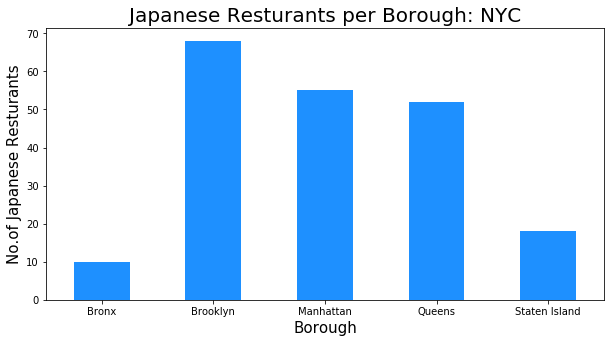

In [37]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Japanese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

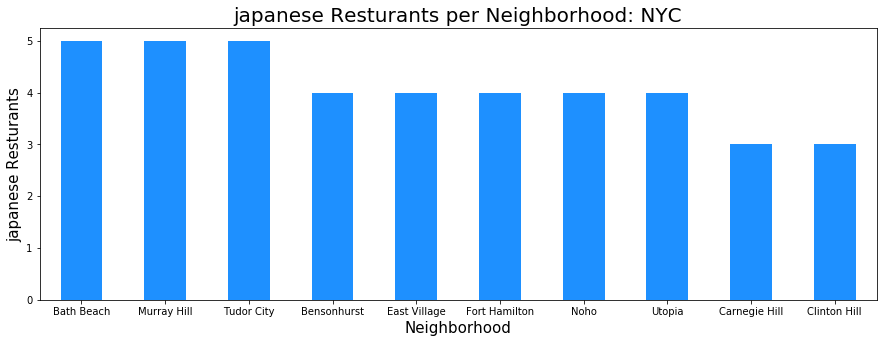

In [36]:
NOofNeigh = 10 # top number for graphing all the same past 10
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(15,5), color=clr)
plt.title('japanese Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('japanese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [38]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Bath Beach']

,Borough,Neighborhood,ID,Name
38,Brooklyn,Bath Beach,51f42bb3498e2681264e00a1,Kasumi Sushi & BBQ Restaurant
39,Brooklyn,Bath Beach,4c326b9fa0ced13ac126156e,Ichi Sushi
40,Brooklyn,Bath Beach,4bad45c9f964a52089403be3,Chikurin
41,Brooklyn,Bath Beach,4b787863f964a52080d02ee3,Shiki Japanese Hibachi
42,Brooklyn,Bath Beach,513e7ec8e4b07f4fa1b53b3d,Fuki Sushi Japanese Restaurant


In [19]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
22,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
23,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
24,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
25,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
45,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


In [39]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Tudor City']

,Borough,Neighborhood,ID,Name
180,Manhattan,Tudor City,559cbaa6498eaa4e8d884811,Tempura Matsui
181,Manhattan,Tudor City,49db8b67f964a520d85e1fe3,Aburiya Kinnosuke
182,Manhattan,Tudor City,4a99b4f4f964a520f62f20e3,Kajitsu
183,Manhattan,Tudor City,591caee89deb7d0f69be77a2,Omusubi Gonbei
184,Manhattan,Tudor City,536ee0fb498e265dd8cb4a93,Tsushima


Let's obtain ratings, likes, and tip for Japanese restaurants

In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough, Neighborhood, ID, Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

In [42]:
japanese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.2,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.2,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.5,26
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,33,7.5,18


In [43]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [44]:
japanese_rest_stats_ny.shape

(203, 7)

In [45]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 7 columns):
Borough         203 non-null object
Neighborhood    203 non-null object
ID              203 non-null object
Name            203 non-null object
Likes           203 non-null object
Rating          203 non-null float64
Tips            203 non-null object
dtypes: float64(1), object(6)
memory usage: 11.2+ KB


In [47]:
japanese_rest_stats_ny['Likes']=japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips']=japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 7 columns):
Borough         203 non-null object
Neighborhood    203 non-null object
ID              203 non-null object
Name            203 non-null object
Likes           203 non-null float64
Rating          203 non-null float64
Tips            203 non-null float64
dtypes: float64(3), object(4)
memory usage: 11.2+ KB


In [48]:
japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,203.000000,203.000000,203.000000
mean,113.995074,7.633990,37.955665
std,205.564894,1.865125,63.217392
min,0.000000,0.000000,0.000000
25%,10.500000,7.200000,5.000000
50%,27.000000,8.000000,11.000000
75%,90.000000,8.750000,34.000000
max,1212.000000,9.300000,354.000000


In [49]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Flatiron
ID              4f7b61f6e4b07aaa5d524842
Name                 OOTOYA 大戸屋 (OOTOYA)
Likes                               1212
Rating                               9.1
Tips                                 274
Name: 187, dtype: object

In [50]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood           East Williamsburg
ID              52517e05498ec2e28c792fa2
Name               Brooklyn Ball Factory
Likes                                296
Rating                               9.3
Tips                                  87
Name: 57, dtype: object

In [31]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                789
Rating                                 9
Tips                                 354
Name: 27, dtype: object

In [51]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
100,Stuyvesant Town,9.200
97,South Side,9.100
37,Flatiron,9.100
23,Cobble Hill,9.100
78,Midtown South,9.100
19,Chinatown,9.100
66,Little Italy,9.100
83,North Side,9.050
82,Noho,9.050
32,East Village,9.025


In [52]:
ny_neighborhood_stats.shape

(117, 2)

In [53]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.689091
1,Brooklyn,7.760294
0,Bronx,7.580000
3,Queens,7.103846
4,Staten Island,5.494444


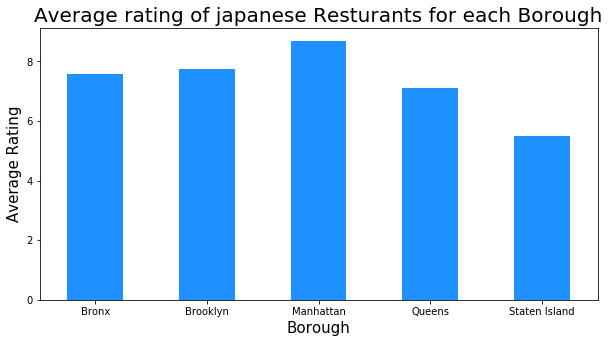

In [54]:
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of japanese Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

We will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the appropriate dfs to include latitudes and longitudes.

In [68]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats.head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,Queens,Astoria,40.768509,-73.915654,8.30,"Astoria, Queens(8.3)"
1,Manhattan,Battery Park City,40.711932,-74.016869,8.70,"Battery Park City, Manhattan(8.7)"
2,Brooklyn,Boerum Hill,40.685683,-73.983748,8.75,"Boerum Hill, Brooklyn(8.75)"
3,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.70,"Brooklyn Heights, Brooklyn(8.7)"
4,Brooklyn,Bushwick,40.698116,-73.925258,8.10,"Bushwick, Brooklyn(8.1)"


In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats.head()

In [59]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [61]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)
ny_geo = 'Neighborhood Tabulation Areas (NTA).geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

Now, we will visualize all NYC boroughs based on average Rating.

In [ ]:
ny_map

Finally, we will visualize NYC Neighborhoods with the best Japanese restaurants based on average Rating.

In [63]:
ny_neighborhood_stats1 = ny_neighborhood_stats.rename(columns={'Neighborhood' : 'ntaname'})

In [64]:
ny_map_N = folium.Map(location=geo_location('New York'), zoom_start=11)
ny_geo = 'Neighborhood Tabulation Areas (NTA).geojson'
ny_map_N.choropleth(
    geo_data=ny_geo,
    data=ny_neighborhood_stats1,
    columns=['ntaname', 'Average Rating'],
    key_on='feature.properties.ntaname',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map_N.save('neighb_rating.html')

In [72]:
ny_neighborhood_stats1.head()

,Borough,ntaname,Latitude,Longitude,Average Rating,Label
0,Queens,Astoria,40.768509,-73.915654,8.30,"Astoria, Queens(8.3)"
1,Manhattan,Battery Park City,40.711932,-74.016869,8.70,"Battery Park City, Manhattan(8.7)"
2,Brooklyn,Boerum Hill,40.685683,-73.983748,8.75,"Boerum Hill, Brooklyn(8.75)"
3,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.70,"Brooklyn Heights, Brooklyn(8.7)"
4,Brooklyn,Bushwick,40.698116,-73.925258,8.10,"Bushwick, Brooklyn(8.1)"


In [ ]:
ny_map_N

#### Results and Discussion

As a result, we obtained a lot of interesting facts about Japanese restaurants in the city of New York: 

1. There are about 203 Japanese restaurants located in all 5 boroughs
2. Brooklyn has the highest number if Japanese restaurants.
3. The neighborhoods of Bath Beach, Murray Hill, and Tudor City have the highest number of Japanese restaurants in all of NYC.
4. The average rating of Japanese restaurant in NYC is 7.6
5. The best Japanese restaurant in NYC according to a rating (9.3) is Brooklyn Ball Factory (East Williamsburg, Brooklyn).
6. The best Japanese restaurant in NYC according to likes is OOTOYA (Flatiron, Manhattan).
7. The best Japanese restaurant in NYC with maximum tips is Morimoto (Chelsea, Manhattan).
8. The best borough with an average rating of Japanese restaurants about 8.7 is Manhattan.
9. The best neighborhood with an average rating of Japanese restaurants about 9.2 is Stuyvesant Town (Manhattan).
10. Most Japanese restaurants with a rating of 8.0 or more are located in the south of Manhattan.

#### Conclusion

As we can see, although most Japanese are restaurants located in Brooklyn, the best places are in Manhattan.
Answering the first question, the best Japanese restaurants are in Stuyvesant Town, South Side, Flatiron, Cobble Hill, Midtown South, Chinatown.

At the same time, according to choropleth map, there are a lot of neighborhoods where Japanese restaurants have ratings below 8 in NYC. Consequently, there is less competition and a better perspective to open new restaurants. Answering the second question, the best place to open a new Japanese restaurant is any neighborhood in the middle part of Manhattan or Tribeca and World Trade Center.

Finally, I would go to Brooklyn Ball Factory (East Williamsburg, Brooklyn) or OOTOYA (Flatiron, Manhattan) in New York City to have the best Japanese food.

 As a final note, all of the above analysis depends on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.